# Exploratory Data Analysis (EDA)

This notebook explores the WatchAlways customer dataset to understand the structure of the data, compute the churn rate, and identify relationships between features and churn.

The goal is to extract insights that support model development for churn prediction.


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("default")
pd.set_option("display.max_columns", 50)


In [69]:
df = pd.read_csv("../input/WatchAlways_customer_churn.csv")
df.head()


,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


## Basic Dataset Information

We start by checking the size, columns, data types, and missing values.  
This helps confirm the dataset is clean and ready for modeling.


In [70]:
# Basic dataset overview 

print("\nMissing values (only columns with missing values):")
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) == 0:
    print("No missing values found.")
else:
    display(missing)

print("\nDuplicate rows:", df.duplicated().sum())

# Split: numeric vs categorical columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

print("\nNumber of numeric columns:", len(num_cols))
print("Number of categorical columns:", len(cat_cols))

print("\nNumeric columns:")
print(num_cols)

print("\nCategorical columns:")
print(cat_cols)


# Key columns
if "watch_hours" in df.columns:
    print("\nwatch_hours sanity check:")
    print("  min:", df["watch_hours"].min())
    print("  max:", df["watch_hours"].max())
    print("  any negative values?", (df["watch_hours"] < 0).any())

if "last_login_days" in df.columns:
    print("\nlast_login_days sanity check:")
    print("  min:", df["last_login_days"].min())
    print("  max:", df["last_login_days"].max())
    print("  any negative values?", (df["last_login_days"] < 0).any())

if "monthly_fee" in df.columns:
    print("\nmonthly_fee sanity check:")
    print("  min:", df["monthly_fee"].min())
    print("  max:", df["monthly_fee"].max())
    print("  any negative values?", (df["monthly_fee"] < 0).any())

# Key categorical distributions
if "subscription_type" in df.columns:
    print("\nTop subscription types:")
    display(df["subscription_type"].value_counts().head(5))

if "region" in df.columns:
    print("\nTop regions:")
    display(df["region"].value_counts().head(5))



Missing values (only columns with missing values):
No missing values found.

Duplicate rows: 0

Number of numeric columns: 7
Number of categorical columns: 7

Numeric columns:
['age', 'watch_hours', 'last_login_days', 'monthly_fee', 'churned', 'number_of_profiles', 'avg_watch_time_per_day']

Categorical columns:
['customer_id', 'gender', 'subscription_type', 'region', 'device', 'payment_method', 'favorite_genre']

watch_hours sanity check:
  min: 0.01
  max: 110.4
  any negative values? False

last_login_days sanity check:
  min: 0
  max: 60
  any negative values? False

monthly_fee sanity check:
  min: 8.99
  max: 17.99
  any negative values? False

Top subscription types:


subscription_type
Premium     1693
Basic       1661
Standard    1646
Name: count, dtype: int64


Top regions:


region
South America    873
Europe           867
North America    851
Asia             841
Africa           803
Name: count, dtype: int64

## Churn Rate

The churn rate is the **percentage of customers who left the platform** (churned = 1).

For example:
- If churn rate is **0.25**, that means **25% of customers churned** and **75% stayed**.
- This matters because it tells us whether the dataset is balanced or not.
- If it’s more balanced, standard metrics become more meaningful.

In [71]:
churn_rate = df["churned"].mean()
print(f"Churn rate: {churn_rate:.3f} ({churn_rate*100:.1f}%)")


Churn rate: 0.503 (50.3%)


## Churn Distribution

This bar chart shows the raw counts of customers who churned vs did not churn.

It’s the simplest way to check:
- whether the dataset is heavily imbalanced
- whether churn is relatively common or rare

Even if we already know the churn rate, the counts are useful because they show how much data we actually have in each class.


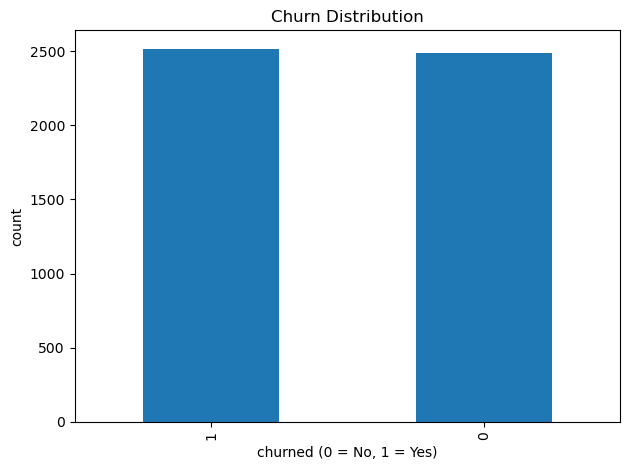

In [72]:
plt.figure()
df["churned"].value_counts().plot(kind="bar")
plt.title("Churn Distribution")
plt.xlabel("churned (0 = No, 1 = Yes)")
plt.ylabel("count")
plt.tight_layout()
plt.show()


## Churn vs Subscription Type

Here we compare churn rate across different subscription plans.

Why this is useful:
- Subscription type is often linked to commitment and price sensitivity.
- If one plan has clearly higher churn, it suggests that plan’s users are either less satisfied or easier to lose.

If we see a strong difference between plans, then `subscription_type` is likely an important feature for predicting churn.



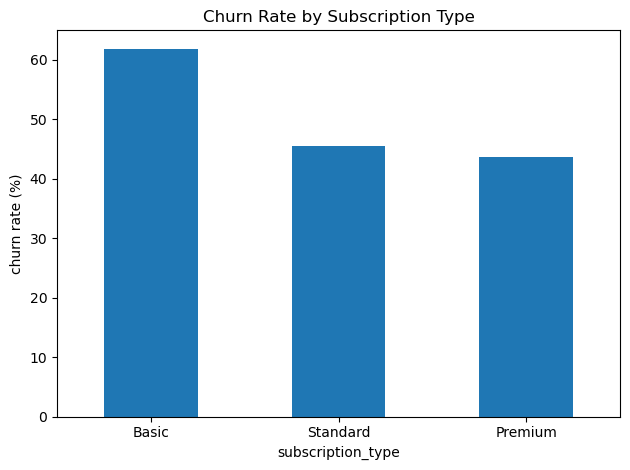

In [73]:
churn_by_sub = df.groupby("subscription_type")["churned"].mean().sort_values(ascending=False)

plt.figure()
(churn_by_sub * 100).plot(kind="bar")
plt.title("Churn Rate by Subscription Type")
plt.ylabel("churn rate (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Churn vs Region

This plot compares churn rate across regions.

Regions can behave differently because of:
- pricing differences / purchasing power
- content preferences
- competition (other streaming platforms)
- differences in how the product is marketed or localized

If some regions churn noticeably more, it’s a clue that churn is influenced by other market-level factors.



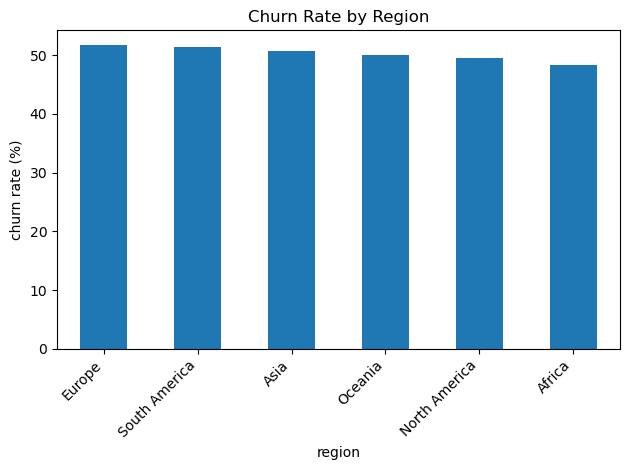

In [74]:
churn_by_region = df.groupby("region")["churned"].mean().sort_values(ascending=False)

plt.figure()
(churn_by_region * 100).plot(kind="bar")
plt.title("Churn Rate by Region")
plt.ylabel("churn rate (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Churn vs Watch Hours


Watch hours is basically a measure of engagement.

- If someone is watching a lot, they’re getting value from the service → less likely to churn.
- If someone barely watches, they might not feel it’s worth paying → more likely to churn.

A boxplot is useful here because it shows the distribution,
so we can see whether churned users are consistently lower in engagement or if there’s lots of overlap.



<Figure size 640x480 with 0 Axes>

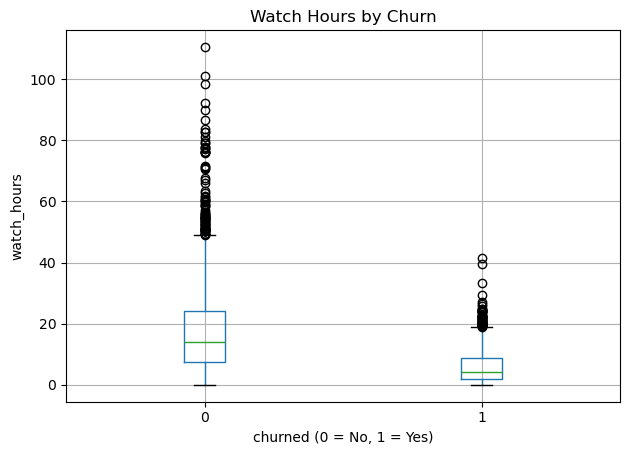

In [75]:
plt.figure()
df.boxplot(column="watch_hours", by="churned")
plt.suptitle("")
plt.title("Watch Hours by Churn")
plt.xlabel("churned (0 = No, 1 = Yes)")
plt.ylabel("watch_hours")
plt.tight_layout()
plt.show()


## Churn vs Last Login Days

`last_login_days` measures how long it has been since the customer last logged in.

This is a strong churn signal in many subscription products:
- People who haven’t logged in for a long time are likely disengaged.

If churned users have noticeably higher values here, it supports the idea that inactivity is one of the clearest warning signs.



<Figure size 640x480 with 0 Axes>

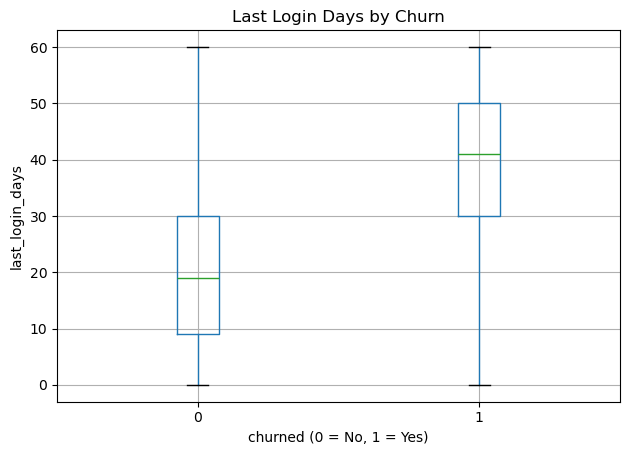

In [76]:
plt.figure()
df.boxplot(column="last_login_days", by="churned")
plt.suptitle("")
plt.title("Last Login Days by Churn")
plt.xlabel("churned (0 = No, 1 = Yes)")
plt.ylabel("last_login_days")
plt.tight_layout()
plt.show()


## Correlation Analysis

This section checks how numeric features move together with churn.

-It’s a quick way to see which variables have the strongest linear relationship with churn.

We mainly look out for correlation values with `churned`.



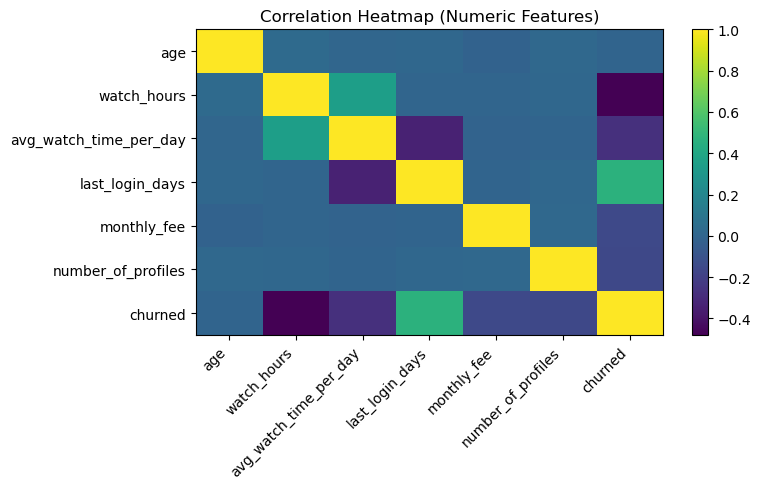

In [77]:
candidate_numeric_cols = [
    "age",
    "watch_hours",
    "avg_watch_time_per_day",
    "last_login_days",
    "monthly_fee",
    "number_of_profiles",
]

numeric_cols = [c for c in candidate_numeric_cols if c in df.columns]

corr = df[numeric_cols + ["churned"]].corr(numeric_only=True)
corr["churned"].sort_values(ascending=False)


plt.figure(figsize=(8, 5))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


# Summary 

- The churn rate is moderate.
- Subscription type appears to influence churn, with Basic customers showing higher churn.
- Certain regions have higher churn rates than others, suggesting location-based behavior.
- Lower watch hours and longer periods since last login correlate with higher churn.
- Numeric correlations confirm that engagement metrics (watch hours, daily watch time) are meaningful predictors.

